# Data Modeling

## Frame the problem
- Based on the **available** dataset, can we **predict** the **number of anime** for each **season** (```Premiered Season```)?
- **Solution**: Build **regression** models to **fit** the data.

## Import

In [1]:
import pandas as pd # For handling and analyzing tabular data

# For visualization
import seaborn as sns
import matplotlib.pyplot as plt

import re # For validating and manipulating text
import numpy as np # For numeric calculation

# For modeling
from sklearn.model_selection import train_test_split # Split train/valid/test dataset
from sklearn.linear_model import LinearRegression # Linear model
from sklearn.preprocessing import PolynomialFeatures # Polynomial regression model
from sklearn.ensemble import RandomForestRegressor # Random Forest Regressor model
from sklearn.ensemble import GradientBoostingRegressor # Gradient Boosting Regressor model
from sklearn.model_selection import GridSearchCV # Hyperparameter tuning for Gradient Boosting Regressor
from sklearn.metrics import mean_squared_error, r2_score # Evaluation metrics

## Read cleaned data from CSV file

In [2]:
anime_data = pd.read_csv('./data/anime_data_cleaned.csv')

# Check
anime_data

,Media Type,Premiered Season,Genres,User Score,Number of Members,Studios,Rating
0,tv,Spring 1979,"Adventure, Anthropomorphic, Comedy, Fantasy, K...",7.86,66328,Shin-Ei Animation,pg
1,tv,Spring 1989,"Action, Adventure, Comedy, Fantasy, Martial Ar...",8.19,1261770,Toei Animation,pg_13
2,tv,Spring 1992,"Comedy, Ecchi, School, Seinen",7.80,87291,Shin-Ei Animation,g
3,tv,Fall 1993,"School, Shounen, Sports, Team Sports",8.55,313954,Toei Animation,pg_13
4,tv,Winter 1994,"Adventure, Comedy, Fantasy, Mahou Shoujo, Roma...",7.40,16950,Gallop,g
...,...,...,...,...,...,...,...
2324,tv,Fall 2024,"Adult Cast, Drama, Seinen",7.03,18379,Madhouse,pg_13
2325,tv,Fall 2024,"Action, Adventure, Fantasy, Harem, Isekai",7.36,139526,asread.,r
2326,tv,Fall 2024,"Comedy, Romance",7.10,94185,Felix Film,pg_13
2327,tv,Fall 2024,"Action, Adventure, Fantasy, Isekai",6.57,86450,"Passione, Hayabusa Film",pg_13


## Extract features and choose factors for model
- In the previous **analysis**, we identified and preliminarily evaluated the **relationship** between $2$ numerical features, ```User Score``` and ```Number of Members```, in relation to the **number of anime**.
- We will conduct further in-depth analyses to **clarify** these **relationships** and determine the **importance** of these features to the **models**.

### Preprocess

- **Construct** a new DataFrame, and **keep** only necessary columns (```Premiered Season```, ```User Score```, and ```Number of Members```):

In [3]:
# Only keep necessary columns for further analysis
modeling_data = anime_data[['Premiered Season', 'User Score', 'Number of Members']]

# Check
modeling_data

,Premiered Season,User Score,Number of Members
0,Spring 1979,7.86,66328
1,Spring 1989,8.19,1261770
2,Spring 1992,7.80,87291
3,Fall 1993,8.55,313954
4,Winter 1994,7.40,16950
...,...,...,...
2324,Fall 2024,7.03,18379
2325,Fall 2024,7.36,139526
2326,Fall 2024,7.10,94185
2327,Fall 2024,6.57,86450


- **Restructuring** the dataset:
    - ```Premiered Season```: Set as the index.
    - ```User Score```: The average ```User Score``` by season (```Premiered Season```).
    - ```Number of Members```: The average ```Number of Members``` by season.

In [4]:
# Season order
season_order = {'Winter': 1, 'Spring': 2, 'Summer': 3, 'Fall': 4}

# Restructure dataset
modeling_data = (
    modeling_data.groupby('Premiered Season', as_index=True)
    .agg({
        'User Score': 'mean',       # Average User Score
        'Number of Members': 'mean' # Average Number of Members
    })
    .round({'User Score': 2, 'Number of Members': 0}) # Round User Score and Number of Members
    .reset_index() # Reset index to manipulate Premiered Season
    .assign(
        Year=lambda df: df['Premiered Season'].str.extract(r'(\d{4})').astype(int),
        Season_Order=lambda df: df['Premiered Season'].str.extract(r'(Winter|Spring|Summer|Fall)')[0].map(season_order)
    )
    .sort_values(by=['Year', 'Season_Order']) # Sort by Year and Season Order
    .drop(columns=['Year', 'Season_Order']) # Drop temporary sorting columns
    .set_index('Premiered Season') # Set Premiered Season back as the index
)

# Check
modeling_data

,User Score,Number of Members
Premiered Season,,
Spring 1979,7.86,66328.0
Spring 1989,8.19,1261770.0
Spring 1992,7.80,87291.0
Fall 1993,8.55,313954.0
Winter 1994,7.40,16950.0
...,...,...
Fall 2023,7.74,198753.0
Winter 2024,7.51,196860.0
Spring 2024,7.85,167159.0


- Create a **new column**: ```Number of Anime```. This column will indicate the **total number** of anime by **season** (```Premiered Season```):

In [5]:
# Add the Number of Anime column using Premiered Season
modeling_data['Number of Anime'] = (
    anime_data['Premiered Season']
    .value_counts()
    .reindex(modeling_data.index) # Align with the existing index
)

modeling_data

,User Score,Number of Members,Number of Anime
Premiered Season,,,
Spring 1979,7.86,66328.0,1
Spring 1989,8.19,1261770.0,1
Spring 1992,7.80,87291.0,1
Fall 1993,8.55,313954.0,1
Winter 1994,7.40,16950.0,1
...,...,...,...
Fall 2023,7.74,198753.0,20
Winter 2024,7.51,196860.0,25
Spring 2024,7.85,167159.0,25


### Examine and analyze the correlation between features

- We will examine the **correlation** between ```Number of Anime``` and ```User Score``` as well as ```Number of Members``` from the **previous** season. This is simply because predicting the **number of anime** for the **current season** based on the ```User Score``` and ```Number of Members``` of that season is **meaningless**.

In [6]:
# Shift User Score and Number of Members columns (1 previous season)
modeling_data['Previous User Score'] = modeling_data['User Score'].shift(1)
modeling_data['Previous Number of Members'] = modeling_data['Number of Members'].shift(1)

# Drop rows where shifted values are NaN (first row will have NaN due to shift)
modeling_data = modeling_data.dropna(subset=['Previous User Score', 'Previous Number of Members'])

# Drop unnecessary columns and rename Previous User Score and Previous Number of Members columns
modeling_data = modeling_data.drop(columns=['User Score', 'Number of Members'])
modeling_data = modeling_data.rename(columns={'Previous User Score': 'User Score', 'Previous Number of Members': 'Number of Members'})

# Check
modeling_data

,Number of Anime,User Score,Number of Members
Premiered Season,,,
Spring 1989,1,7.86,66328.0
Spring 1992,1,8.19,1261770.0
Fall 1993,1,7.80,87291.0
Winter 1994,1,8.55,313954.0
Spring 1994,4,7.40,16950.0
...,...,...,...
Fall 2023,20,7.60,212331.0
Winter 2024,25,7.74,198753.0
Spring 2024,25,7.51,196860.0


In [7]:
# Check correlation
corr = modeling_data.corr()
corr

,Number of Anime,User Score,Number of Members
Number of Anime,1.000000,0.102568,0.265141
User Score,0.102568,1.000000,0.609193
Number of Members,0.265141,0.609193,1.000000


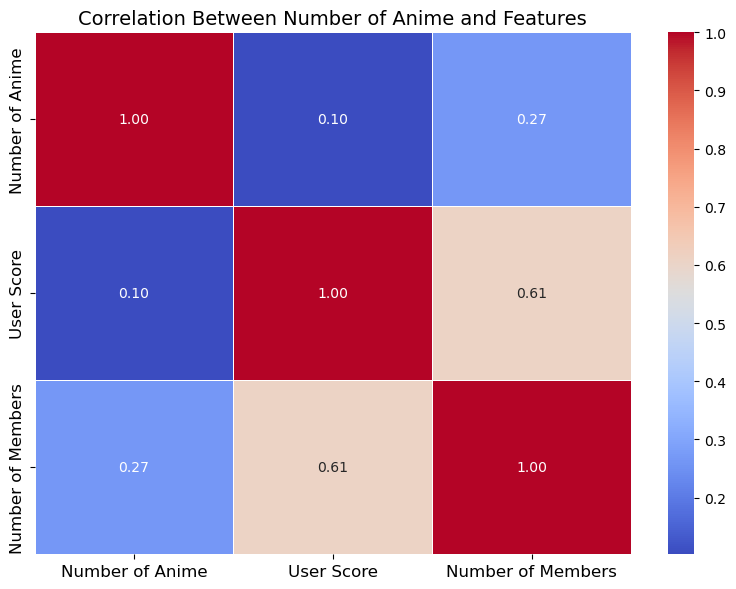

In [8]:
# Visualize by using heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title("Correlation Between Number of Anime and Features", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

- **Comments**:
    - The **correlation** between ```Number of Anime``` and ```User Score```, as well as ```Number of Members```, is **weak positive** ($\approx 0.10$ and $\approx 0.27$) $\rightarrow$ Individual features are **hardly** able to **fully generalize** the ```Number of Anime```.
    - The **correlation** between ```User Score``` and ```Number of Members``` is **moderately strong positive** ($\approx 0.61$) $\rightarrow$ **Strong enough** to consider removing one and **using only** the other in the model. However, since the current number of features is very **limited**, we still **need** to use **both** features.

$\rightarrow$ We will use the **two features**, ```User Score``` and ```Number of Members```, as the **main factors** for the model predicting the **Number of Anime** by season.

## Loss Function and Model Evaluation
### Loss function
- **Measure** how far off a model's predictions are from the actual values $\rightarrow$ It is used during the **training process** to guide the model in learning.
- In this project, we will only use the most common loss function, **Mean Squared Error** (MSE): Measures the **average squared difference** between the predicted and actual values.
- Formula: $\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} \left( y_i - \hat{y}_i \right)^2$, where:
    - $n$: Number of data points.
    - $y_i$: Actual value of the target variable.
    - $\hat{y}_i$: Predicted value of the target variable.

### Model evaluation
- **Evaluates** the explanatory power of a model after training, providing insight into how well the model fits the data.
- In this project, we will only use $\text{R}^2$ metric to measure the **proportion of the variance** in the target variable that is explained by the model.
- Formula: $\text{R}^2 = 1 - \frac{\text{SS}_\text{res}}{\text{SS}_\text{tot}}$, where:
    - $\text{SS}_\text{res} = \sum (y_i - \hat{y}_i)^2$: Residual sum of squares (**RSS**) (explains prediction errors).
    - $SS_{\text{tot}} = \sum (y_i - \overline{y})^2$: Total sum of squares (explains **variance** in actual values).
- Interpretation:
    - $\text{R}^2 = 1$: **Perfect** model (explains 100% of the variance).
    - $\text{R}^2 \leq 0$: The model performs **no better** or **worse** than simply using the mean of $y$ as the prediction (useless).

## Split train/validation/test dataset
Our dataset **contains** only 126 samples (a **relatively small** number). Therefore, to **improve** the **performance** of the models, we will **split** the original dataset as follows:
- For regression models **without** hyperparameters (e.g., linear model): Train: $90 \%$, Test: $10 \%$.
- For regression models **with** hyperparameters (e.g., polynomial, random forest regressor, etc.): Train: $80 \%$, Validation: $10 \%$, Test: $10 \%$. 

## Linear Regression
- Model: $\text{Number of Anime} = a \cdot \text{User Score} + b \cdot \text{Number of Members} + c\ (a, b, c \in R)$
- For **Linear Regression**, since there are **no hyperparameters**, we will only **split** the dataset into **two** parts: Train ($90 \%$) and Test ($10 \%$).

In [9]:
X = modeling_data[['User Score', 'Number of Members']]
y = modeling_data['Number of Anime']

# Split the data into training and testing sets (90% train, 10% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Train model and fit data
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation metrics
linear_mse = mean_squared_error(y_test, y_pred)
linear_r2 = r2_score(y_test, y_pred)

# Print the result
print(f"MSE: {linear_mse:.2f}, R²: {linear_r2:.2f}")

MSE: 51.34, R²: 0.23


- Extract the model and retrieve the parameters ($a, b, c$):

In [10]:
# Coefficients
print("Coefficients:")
for feature, coef in zip(X.columns, model.coef_):
    print(f"{feature}: {coef:.7f}")
print(f"Intercept: {model.intercept_:.7f}")

Coefficients:
User Score: -2.8018743
Number of Members: 0.0000149
Intercept: 35.4624411


- **Comments**:
    - Linear model to predict ```Number of Anime``` based on ```User Score``` and ```Number of Members```: $\text{Number of Anime} = -2.0818743 \cdot \text{User Score} + 0.0000149 \cdot \text{Number of Members} + 35.4624411$, which means:
        - When the ```User Score``` **decreases**, the ```Number of Anime``` **increases**, and vice versa $\rightarrow$ This aligns relatively well with **previous analysis results**; however, there are still some **inconsistencies** compared to **reality**.
        - When the ```Number of Members``` **increases**, the ```Number of Anime``` also **increases**, and vice versa -> This has **no conflict** with **reality**.
$\rightarrow$ The $\text{R}^2$ score is only $\approx 0.23$, and the **parameters** in the model cause some **inconsistencies** compared to **reality**, indicating that the **linear regression** model is **not suitable** for this problem $\rightarrow$ Better models are needed.

## Random Forest Regressor
- There are **two** important things we need to focus on with this regression method:
    - **Hyperparameters** tuning: **Random Forest** generally works well with default settings, but **hyperparameter tuning** can optimize performance:
        - ```n_estimators```: The number of decision trees in the random forest. Increasing ```n_estimators``` **improves** the model's performance by reducing variance, but **waste** more time and usually **stabilize** accuracy after a certain point.
        - ```max_depth```: The maximum depth of each decision tree. Limiting the maximum depth of each decision tree will help to reduce both **overfitting** and **underfitting**.
        - ```min_samples_split```: The minimum number of samples required to split an internal node. Higher values prevent the tree from growing too complex (reduce overfitting) and lower values allow splits even for small sample sizes, which can lead to overfitting.
        - ```min_samples_leaf```: The minimum number of samples required to be at a leaf node. Larger values ensure leaf nodes have more samples, reducing overfitting and lower values allow smaller leaf sizes, capturing more specific patterns but increasing risk of overfitting.
    - **Feature Importance**: Analyzing the **influence** of each **feature** on the predictive model.
- **Split** dataset: Train: $80 \%$, Validation: $10 \%$, Test: $10 \%$. 

In [11]:
# Split the data into training, validating and testing sets (80% train, 10% validation, 10% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42) # 80% train
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42) # 10% validation, 10% test

In [12]:
# Hyperparameters to test
hyperparameters = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 5]
}

In [13]:
best_model = None
best_score = float('-inf')
best_params = {}

# Hyperparameter tuning
for n in hyperparameters['n_estimators']:
    for depth in hyperparameters['max_depth']:
        for split in hyperparameters['min_samples_split']:
            for leaf in hyperparameters['min_samples_leaf']:
                # Train a Random Forest model with the current set of hyperparameters
                model = RandomForestRegressor(
                    n_estimators=n,
                    max_depth=depth,
                    min_samples_split=split,
                    min_samples_leaf=leaf,
                    random_state=42
                )
                model.fit(X_train, y_train)
                
                # Validate the model
                y_val_pred = model.predict(X_val)
                score = r2_score(y_val, y_val_pred)  # Evaluation metric
                
                # Update the best model if the current one is better
                if score > best_score:
                    best_model = model
                    best_score = score
                    best_params = {
                        'n_estimators': n,
                        'max_depth': depth,
                        'min_samples_split': split,
                        'min_samples_leaf': leaf
                    }
                    
# Print result
print("Best Hyperparameters:", best_params)
print(f"Best Validation R²: {best_score:.2f}")

Best Hyperparameters: {'n_estimators': 500, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 5}
Best Validation R²: -0.32


In [14]:
# Evaluate the best model on the test set
y_test_pred = best_model.predict(X_test)

# Evaluation metrics
rfr_mse = mean_squared_error(y_test, y_test_pred)
rfr_r2 = r2_score(y_test, y_test_pred)

# Print the result
print("Final Test Evaluation")
print(f"MSE: {rfr_mse:.2f}")
print(f"R²: {rfr_r2:.2f}")

Final Test Evaluation
MSE: 71.35
R²: 0.35


- Visualize the **importance** of each feature in Random Forest Regressor model:

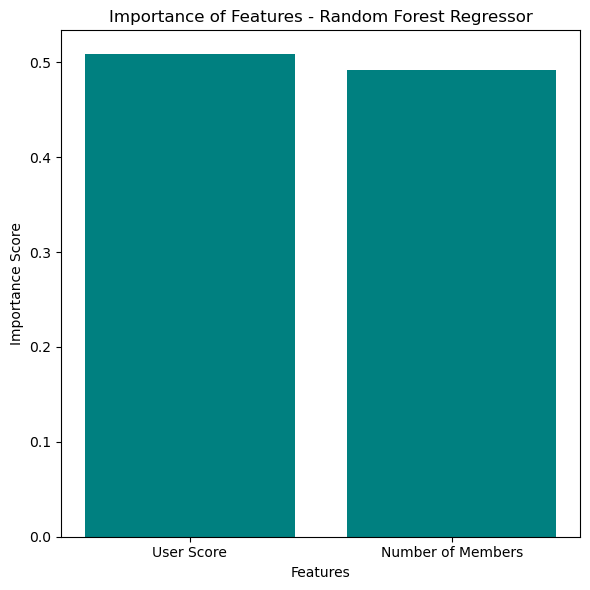

In [15]:
# Visualize the importance of features by using horizontal bar chart
feature_importances = model.feature_importances_
features = X_train.columns

# Sorting decreasingly
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)  # Sort by importance

# Visualization
plt.figure(figsize=(6, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'], color='teal')  # Use plt.bar for vertical bars
plt.title("Importance of Features - Random Forest Regressor")
plt.xlabel("Features")
plt.ylabel("Importance Score")

plt.tight_layout()
plt.show()

- **Comments**:
    - The $\text{R}^2$ score has **improved significantly** compared to previous models; however, it is still **not high enough** to consider this a **good model**.
    - The $\text{R}^2$ score of the **validation** dataset shows a **significant discrepancy** ($<0$) compared to the $\text{R}^2$ score of the **test** dataset, indicating a **lack of samples** (only $10$ samples for each validation and test dataset).
    - For this Random Forest model, the **importance** of the two features, ```User Score``` and ```Number of Members```, is quite **similar** ($\approx 0.5$).

$\rightarrow$ Although there has been some **improvements**, this is still **not** a **sufficiently robust** model to address the initial problem effectively.

## Polynomial Regression

- **Split** dataset: Train: $80 \%$, Validation: $10 \%$, Test: $10 \%$.
- **Hyperparameter(s)**: The polynomial degree.

In [16]:
# Hyperparameter tuning for Polynomial Regression
best_degree = None
best_model = None
best_score = float('-inf')
results = []  # To store results for each degree

# Test polynomial degrees from 2 to 10 
for degree in range(2, 10):
    # Create polynomial features
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)

    # Train a linear regression model
    model = LinearRegression()
    model.fit(X_train_poly, y_train)

    # Validate the model
    y_val_pred = model.predict(X_val_poly)
    score = r2_score(y_val, y_val_pred)  # R² on validation set
    
    # Store results
    results.append({'Degree': degree, 'Validation R²': score})
    
    # Update the best model if the current one is better
    if score > best_score:
        best_degree = degree
        best_model = model
        best_score = score

# Print the best degree and validation score
print("Best Polynomial Degree:", best_degree)
print(f"Best Validation R²: {best_score:.2f}")

Best Polynomial Degree: 8
Best Validation R²: -0.19


In [17]:
# Evaluate the best model on the test set
poly = PolynomialFeatures(degree=best_degree)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
y_test_pred = best_model.predict(X_test_poly)

# Test set evaluation metrics
poly_r2 = r2_score(y_test, y_test_pred)
print("Final Test Evaluation")
print(f"R² on test set: {poly_r2:.2f}")

Final Test Evaluation
R² on test set: 0.41


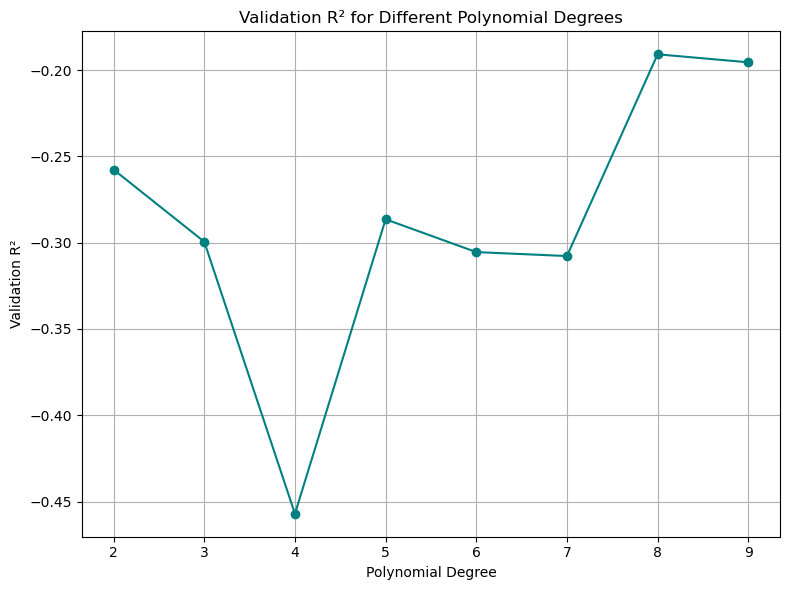

In [18]:
# Visualize the validation results
results_df = pd.DataFrame(results)
plt.figure(figsize=(8, 6))
plt.plot(results_df['Degree'], results_df['Validation R²'], marker='o', color='teal')
plt.title("Validation R² for Different Polynomial Degrees")
plt.xlabel("Polynomial Degree")
plt.ylabel("Validation R²")
plt.grid(True)
plt.tight_layout()
plt.show()

- **Comments**:
    - The $\text{R}^2$ score for the Polynomial Regression model with degree 8 has improved compared to the linear models; however, it is still not satisfactory as a reliable predictor.
    - The $\text{R}^2$ score on the validation dataset ($-0.19$) is significant lower than that on the test dataset ($0.41$), which indicates the model is not very reliable and lacks sufficient samples.
    - While the Polynomial Regression model is more capable of capturing non-linear relationships, its predictive power remains limited with the current feature set.

$\rightarrow$ Overall, this model has shown some improvements compared to simpler models, but it is still not robust enough to effectively address the problem.

## Gradient Boosting Regressor

- **Split** dataset: Train: $80 \%$, Validation: $10 \%$, Test: $10 \%$.
- **Hyperparameter(s)**: 
    - `n_estimators`:
        - Represents the number of trees in the ensemble.
        - A higher value allows the model to learn more complex patterns but increases computational cost.
        - Tested values: `[100, 200, 500]`.
    - `learning_rate`:
        - Controls the step size at which the model learns. Smaller values make the model learn more slowly but can yield better generalization.
        - Trade-off: A smaller learning rate often requires a larger number of trees to converge.
        - Tested values: `[0.01, 0.1, 0.2]`.
    - `max_depth`:
        - Specifies the maximum depth of each tree.
        - Deeper trees can model more complex patterns but are more prone to overfitting.
        - Tested values: `[3, 5, 10]`.
    - `min_samples_split`:
        - Defines the minimum number of samples required to split an internal node.
        - Larger values make the model more conservative by requiring more samples to split nodes.
        - Tested values: `[2, 5, 10]`.

In [19]:
# Define the model
gbr = GradientBoostingRegressor(random_state=42)

# Define hyperparameters to tune
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
}

In [20]:
# Grid search for the best hyperparameters
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=3, scoring='r2', verbose=1)
grid_search.fit(X_train, y_train)

# Get the best model and evaluate
best_gbr = grid_search.best_estimator_
y_val_pred = best_gbr.predict(X_val)
r2_val = r2_score(y_val, y_val_pred)

print(f"Best Gradient Boosting Model R² on test set: {r2_val:.3f}")

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Gradient Boosting Model R² on test set: -0.160


In [21]:
# Evaluate the best Gradient Boosting model on the test set
y_test_pred = best_gbr.predict(X_test)

gbr_mse = mean_squared_error(y_test, y_test_pred)
gbr_r2 = r2_score(y_test, y_test_pred)

# Print the results
print("Final Test Evaluation for Gradient Boosting Regressor")
print(f"MSE: {gbr_mse:.2f}")
print(f"R²: {gbr_r2:.2f}")

Final Test Evaluation for Gradient Boosting Regressor
MSE: 74.81
R²: 0.32


- Visualize the **importance** of each feature in Gradient Boosting Regressor model:

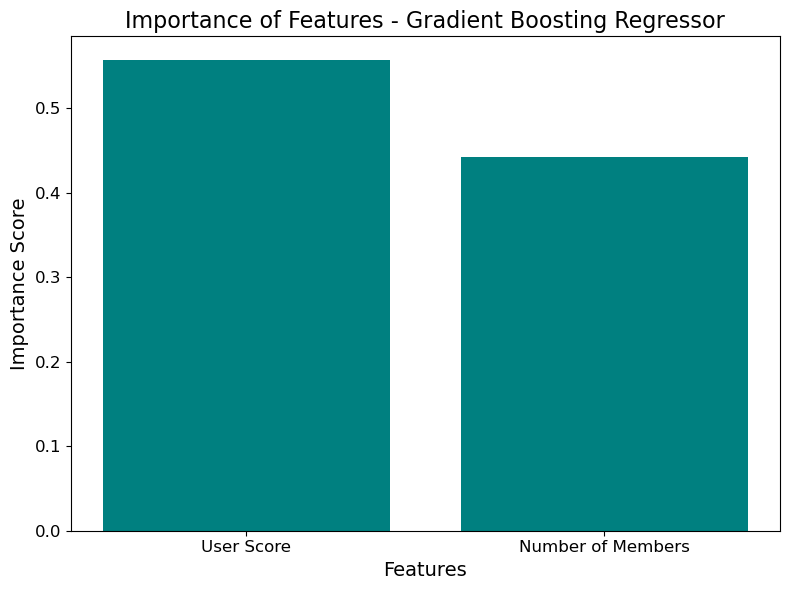

In [22]:
# Extract feature importances from the Gradient Boosting model
feature_importances = best_gbr.feature_importances_
features = X_train.columns 

# Create a DataFrame to store and sort feature importances
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False) # Sort by importance

# Visualization: Vertical bar chart
plt.figure(figsize=(8, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'], color='teal')
plt.title("Importance of Features - Gradient Boosting Regressor", fontsize=16)
plt.xlabel("Features", fontsize=14)
plt.ylabel("Importance Score", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

- **Comments**:
    - The $\text{R}^2$ score of the **Gradient Boosting Regressor** model is **slightly better** than simpler models such as **Polynomial Regression** and **Linear Regression**, achieving a value of $0.31$ on the test set.
    - The $\text{R}^2$ score indicates that the model can explain approximately **31% of the variance** in the target variable, which is an **incremental improvement** but still below the acceptable threshold for a strong predictive model.
    - The **Mean Squared Error (MSE)** of $45.45$ suggests that there is still a significant difference between the predicted and actual values, leaving room for improvement.
    - Hyperparameter tuning with 81 combinations showed that the best model configuration still struggles to capture the complexities of the dataset.

$\rightarrow$ While Gradient Boosting Regressor has demonstrated **better performance** compared to earlier models, it is **not sufficient** to fully solve the problem.

## Conclusions

- Visualize the **best result** ($\text{MSE}$ value) from the processed models above:

In [23]:
# Store R² results in a dictionary and convert it into a DataFrame
r2_results = {
    'Linear Regression': linear_r2,
    'Polynomial Regression': poly_r2,
    'Random Forest Regressor': rfr_r2,
    'Gradient Boosting Regressor': gbr_r2
}

r2_df = pd.DataFrame(list(r2_results.items()), columns=['Model', 'R2'])

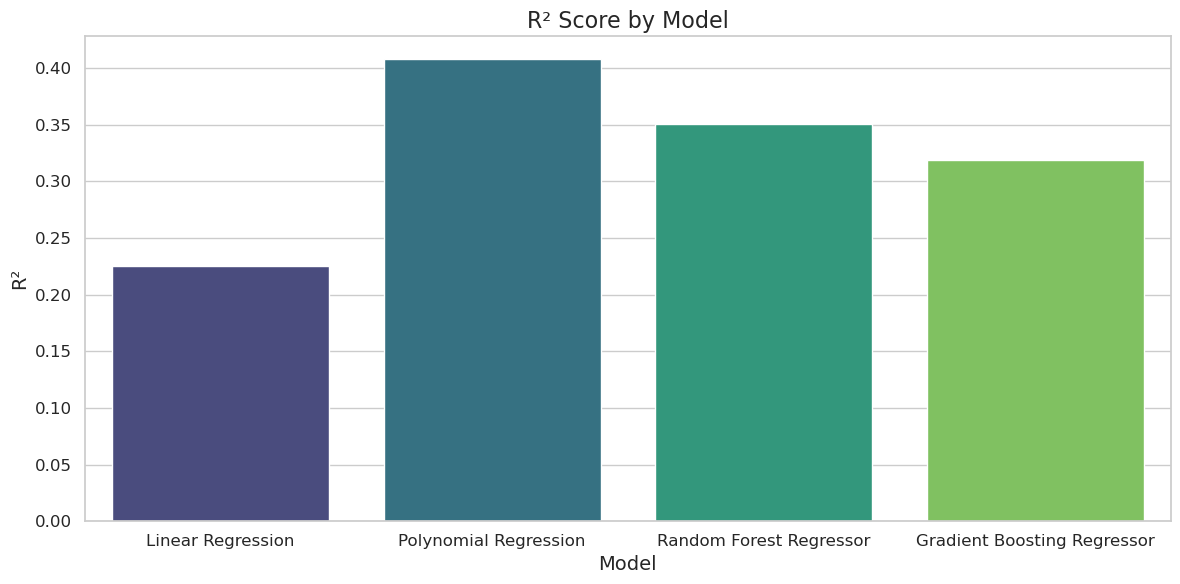

In [24]:
# Visualize by using vertical bar chart
sns.set_theme(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='R2', data=r2_df, palette='viridis', hue='Model', dodge=False)
plt.title("R² Score by Model", fontsize=16)
plt.xlabel("Model", fontsize=14)
plt.ylabel("R²", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

- The **best model** is: **Polynomial Regression**.
- However, the $\text{R}^2$ score of all models are unimpressive ($\leq 0.41$) and reveal **inconsistencies** in the modeling process, meaning that **none** of the models can **effectively address** the original problem.
- Some **potential** solutions:
    - **Collect** more data: **Increase** the number of **samples** or **features**.
    - **Select** and **analyze** additional features: Choose more **categorical** features (**encoded** numerically) or derive **hidden features** based on the current dataset.
    - **Apply** more **complex models**.